### DDoS Detection using Machine Learning Models 
 **- CIC-DDoS2017 Dataset**
 
 **- Group 18**


### Imports and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


In [2]:
def find_categorical_columns(data):
    columns = []
    for column in data.columns:
            unique_values = data[column].nunique()    #number of unique values               
            if unique_values in [1, 2, 3, 4,5]:
                print(f"{column} : {unique_values} unique values.")
                data[column] = data[column].astype('category')
                columns.append(column)
    print('done converting to categorical . . .')
    return columns    

In [3]:
#check for infinite values 
def handle_infinite_values(data):
    if data.isin([np.inf, -np.inf]).any().any():
        infinite_values = data.isin([np.inf, -np.inf])

        # Display rows with infinite values
        rows_with_infinite = data[infinite_values.any(axis=1)]
        print(f"Count of Rows with Infinite Values: {len(rows_with_infinite)}")

        # Replace infinite values with NaN
        data = data.replace([np.inf, -np.inf], np.nan)
        print('cleaning is done . . .')
        
    else:
        print('No Infinite Values Present')
        data.isin([np.inf, -np.inf]).sum().sum()
    return data

In [4]:
def handle_nan_values(data):
    # Check for NaN values
    if data.isnull().any().any():
        print(f"Count of NaN values:{data.isnull().sum().sum()}")
        # Handle NaN values
        data = data.fillna(data.mean()) 
        data.isnull().sum().sum()
        print("cleaning is done . . .")
    else:
        print("No NaN Values are Present")
        data.isnull().sum().sum()
    return data

In [5]:
def custom_encode(data, column_name):
    unique_values = data[column_name].unique()
    print(f"Categories : {unique_values}")
    encoding_dict = {value: index for index, value in enumerate(unique_values)}
    
    data[column_name] = data[column_name].map(encoding_dict)
    unique_values_encoded = data[column_name].unique()
    print(f"Encoded Categories : {unique_values_encoded}")
    return data
    

In [6]:
def handle_duplicates(data):
    # Check for duplicated records
    duplicates = data[data.duplicated(keep=False)]
    shape = data.shape
    if duplicates.empty:
        print("No duplicated records found.")
        return data

    print(f"Count of Duplicated Records: {len(duplicates)}")
    data = data.drop_duplicates(keep='first')
    new_shape = data.shape
    print(f"Keeping first occurrence of duplicated records.\nShape Before Cleaning: {shape},\nShape After Cleaning: {new_shape}")
    return data

In [7]:
def handle_correlated_features(data, high_threshold=0.95, low_threshold=0.2):
    """
    Removing Highly Correlated Features:
    Why? When two or more features in your data are very similar, it can confuse some types of analyses or machine learning models.

    What to do? Look for pairs of features that are almost the same. If you find them, you might remove one to simplify your analysis or model.

    Removing Lowly Correlated Features:
    Why? Some features might not be very useful for predicting what you're interested in (like your target variable).

    What to do? Identify features that don't seem to change much when your target variable changes. If they don't help much, consider getting rid of them.
    """

    # Calculate the correlation matrix
    corr_matrix = data.corr().abs()

    high_mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    low_mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)

    # Get the indices of feature pairs with correlation above the high threshold
    high_pairs_to_drop = [(i, j) for i in range(corr_matrix.shape[0]) for j in range(i + 1, corr_matrix.shape[1]) if high_mask[i, j] and corr_matrix.iloc[i, j] >= high_threshold]

    # Get the indices of feature pairs with correlation below the low threshold
    low_pairs_to_drop = [(i, j) for i in range(corr_matrix.shape[0]) for j in range(i + 1, corr_matrix.shape[1]) if low_mask[i, j] and corr_matrix.iloc[i, j] <= low_threshold]

    if not high_pairs_to_drop and not low_pairs_to_drop:
        print("No highly or lowly correlated features found.")
        return data
    if not high_pairs_to_drop:
        print("No highly correlated features found.")
    if not low_pairs_to_drop:
        print("No lowly correlated features found.")
    
    print("Highly Correlated Features:")
    for i, j in high_pairs_to_drop:
        print(f"{data.columns[i]} - {data.columns[j]} : {corr_matrix.iloc[i, j]}")

    print("\nLowly Correlated Features:")
    for i, j in low_pairs_to_drop:
        print(f"{data.columns[i]} - {data.columns[j]} : {corr_matrix.iloc[i, j]}")

    # Combine the feature pairs to drop
    all_pairs_to_drop = high_pairs_to_drop + low_pairs_to_drop

    # Remove highly and lowly correlated features
    df_cleaned = data.drop(columns=[data.columns[i] for i, _ in all_pairs_to_drop])

    print(f"\nRemoved {len(all_pairs_to_drop)} correlated features.")
    
    return df_cleaned


In [8]:
import seaborn as sns

def explore_features(data):
    # Create subplots
    fig, axes = plt.subplots(nrows=data.shape[1], ncols=1, figsize=(10, 4 * data.shape[1]))
    fig.subplots_adjust(hspace=0.5)

    # Iterate through columns
    for i, (colname, coldata) in enumerate(data.iteritems()):
        ax = axes[i]

        # # Plot based on data type
        if pd.api.types.is_numeric_dtype(coldata):
            # Handle numeric (int and float) data
            coldata.plot(kind='hist', ax=ax)
            ax.set_title(f'Distribution of {colname}')
            ax.set_xlabel(colname)
            ax.set_ylabel('Frequency')
        # if pd.api.types.is_numeric_dtype(coldata):
        #     # Handle numeric (int and float) data
        #     sns.histplot(coldata, kde=True, ax=ax)
        #     ax.set_title(f'Distribution of {colname}')
        #     ax.set_xlabel(colname)
        #     ax.set_ylabel('Frequency')

        elif pd.api.types.is_categorical_dtype(coldata):
            # Handle categorical data
            sns.countplot(x=colname, data=data, ax=ax)
            ax.set_title(f'Count of {colname}')
            ax.set_xlabel(colname)
            ax.set_ylabel('Count')

        else:
            # Handle other data types (assuming non-numeric and non-categorical)
            ax.text(0.5, 0.5, f'Unsupported data type\n({pd.api.types.infer_dtype(coldata)})', 
                    ha='center', va='center', fontsize=12, color='red')
            ax.axis('off')

    plt.show()


In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def classification(model, X_train, X_test, y_train, y_test,title=''):
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

    print(f"Accuracy of {model}: {acc}%" )
    print(f"F1 Score of {model}: {f1}%" )
    target_names = ['0:Benign', '1:Attack']
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(6, 6), cmap = plt.cm.Blues)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title(f'Confusion Matrix on {title}', fontsize=18)
    return y_pred, clf, acc, f1

In [10]:
def overall_cv_classification(model, X, y, folds):
    y_pred = cross_val_predict(model, X, y, cv = folds)
    accuracy = accuracy_score(y_pred,y)*100
    percision = precision_score(y, y_pred)*100
    recall = recall_score(y, y_pred)*100
    f1 = f1_score(y, y_pred)*100
    
    print(f"Accuracy_score: {accuracy}",)
    print(f"precision_score: {percision}")
    print(f"recall_score: {recall}")
    print(f"f1_score: {f1}")
  
    cm = confusion_matrix(y, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(6, 6), cmap = plt.cm.Blues)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [11]:
def plot_target_distribution(df, target_column):
    plt.figure(figsize=(8, 6))
    df[target_column].value_counts().plot(kind='bar', color=['#a060ad', '#dd90b6'])
    plt.title(f'Distribution of {target_column}')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()

In [12]:
def perform_grid_search(model, parameters, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search

In [13]:
def plot_predictions(y_true,y_pred): 
    plt.figure(figsize=(30, 6))
    plt.scatter(np.arange(len(y_true)), y_true, color='blue', label='True Values', marker='o')
    plt.scatter(np.arange(len(y_pred)), y_pred, color='red', alpha=0.9, label='Predicted Values', marker='x')
    plt.xlabel('Data Points')
    plt.ylabel('Binary Classification (0/1)')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
def data_scaling(X_train,X_val,X_test):
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform the training data
    X_train_scaled = scaler.fit_transform(X_train)

    # Use the same scaler to transform the validation and test data
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled,X_val_scaled,X_test_scaled

### Load Data

In [15]:
data = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
print(data.shape)

(225745, 79)


In [16]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [17]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225745.00000,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,...,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,8879.61946,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,27.882221,164.826715,214.907242,...,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
std,19754.64740,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,163.324159,504.892965,797.411073,...,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07
min,0.00000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,80.00000,7.118000e+04,2.000000,1.000000,26.000000,0.000000e+00,6.000000,0.000000,6.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.00000,1.452333e+06,3.000000,4.000000,30.000000,1.640000e+02,20.000000,0.000000,8.666667,5.301991,...,2.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,80.00000,8.805237e+06,5.000000,5.000000,63.000000,1.160100e+04,34.000000,6.000000,32.000000,10.263203,...,4.000000,20.000000,1.878000e+03,0.000000e+00,1.878000e+03,1.862000e+03,8.239725e+06,0.000000e+00,8.253838e+06,7.422849e+06
max,65532.00000,1.199999e+08,1932.000000,2942.000000,183012.000000,5.172346e+06,11680.000000,1472.000000,3867.000000,6692.644993,...,1931.000000,52.000000,1.000000e+08,3.950000e+07,1.000000e+08,1.000000e+08,1.200000e+08,6.530000e+07,1.200000e+08,1.200000e+08


In [18]:
#data types of all columns
data.dtypes

 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                          object
Length: 79, dtype: object

In [19]:
data.max()

 Destination Port                    65532
 Flow Duration                   119999937
 Total Fwd Packets                    1932
 Total Backward Packets               2942
Total Length of Fwd Packets         183012
                                  ...     
Idle Mean                      120000000.0
 Idle Std                       65300000.0
 Idle Max                        120000000
 Idle Min                        120000000
 Label                                DDoS
Length: 79, dtype: object

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet Length Mean       225745 non-nul

### Preprocessing (Feature Engineering and Data Cleaning)

In [21]:
# remove spaces presented in col names
df = data.copy()
df.columns = df.columns.str.replace(' ', '') 

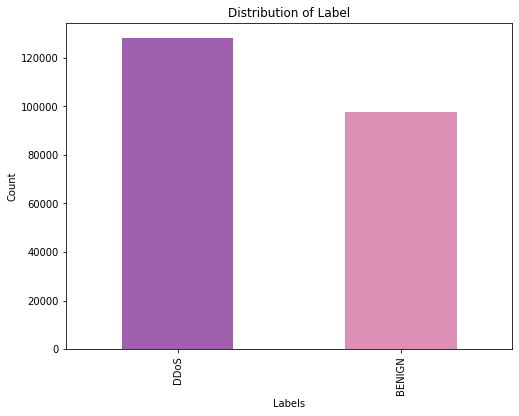

In [22]:
plot_target_distribution(df, 'Label')

In [23]:
df["Label"].value_counts()

DDoS      128027
BENIGN     97718
Name: Label, dtype: int64

In [24]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', 100)
df.describe()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
count,225745.00000,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,2.257410e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,225745.000000,225745.0,225745.0,225745.0,225745.000000,225745.000000,2.257450e+05,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.0,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.0,225745.0,225745.0,225745.0,225745.0,225745.0,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,8879.61946,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,27.882221,164.826715,214.907242,2735.585147,16.718776,890.536849,1230.172938,inf,inf,1.580587e+06,4.248569e+06,1.348977e+07,2.811855e+04,1.539652e+07,2.540610e+06,5.195207e+06,1.299434e+07,2.073698e+05,6.564701e+06,9.476322e+05,1.610306e+06,4.567514e+06,2.257817e+05,0.033223,0.0,0.0,0.0,111.522718,106.789023,1.261508e+04,1.641693e+03,8.072595,3226.045339,515.002137,1085.593207,2.789906e+06,0.002671,0.033223,0.000120,0.351162,0.504463,0.140752,0.0,0.000120,1.005821,574.568843,164.826715,890.536849,111.522718,0.0,0.0,0.0,0.0,0.0,0.0,4.874916,939.463346,4.572775,5.960477e+03,4247.436922,601.048635,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
std,19754.64740,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,163.324159,504.892965,797.411073,3705.123460,50.480568,1120.324921,1733.201267,NaN,NaN,2.701596e+06,7.622819e+06,2.670172e+07,7.598100e+05,3.160826e+07,5.934694e+06,1.078635e+07,2.748870e+07,3.795228e+06,2.198455e+07,4.586374e+06,5.475778e+06,1.617865e+07,4.019290e+06,0.179220,0.0,0.0,0.0,375.790727,511.765795,1.106701e+05,1.989593e+04,15.767713,3813.134850,559.064495,1269.558714,4.115941e+06,0.051614,0.179220,0.010936,0.477334,0.499981,0.347766,0.0,0.010936,1.430781,626.096202,504.892965,1120.324921,375.790727,0.0,0.0,0.0,0.0,0.0,0.0,15.422874,3249.403484,21.755356,3.921834e+04,8037.781019,4319.720339,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07
min,0.00000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.200000e+07,-2.000000e+06,-1.000000e+00,0.000000e+00,-1.00000

In [25]:
df['Label'].value_counts(),df['DestinationPort'].value_counts() 

(DDoS      128027
 BENIGN     97718
 Name: Label, dtype: int64,
 80       136951
 53        31950
 443       13485
 8080        510
 123         362
           ...  
 33446         1
 60075         1
 15025         1
 27323         1
 10235         1
 Name: DestinationPort, Length: 23950, dtype: int64)

In [26]:
df.shape

(225745, 79)

In [27]:
df = handle_duplicates(df)

Count of Duplicated Records: 3940
Keeping first occurrence of duplicated records.
Shape Before Cleaning: (225745, 79),
Shape After Cleaning: (223112, 79)


In [28]:
df = handle_infinite_values(df)

Count of Rows with Infinite Values: 30
cleaning is done . . .


In [29]:
df = handle_nan_values(df)

Count of NaN values:60


cleaning is done . . .


In [30]:
pd.set_option('display.max_columns', 100)
df.describe()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
count,223112.000000,2.231120e+05,223112.000000,223112.000000,223112.000000,2.231120e+05,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,223112.000000,223112.0,223112.0,223112.0,223112.000000,223112.000000,2.231120e+05,2.231120e+05,223112.000000,223112.000000,223112.000000,223112.000000,2.231120e+05,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.0,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.0,223112.0,223112.0,223112.0,223112.0,223112.0,223112.000000,223112.000000,223112.000000,2.231120e+05,223112.000000,223112.000000,223112.000000,223112.000000,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05
mean,8982.617537,1.643322e+07,4.905375,4.611554,949.663380,6.029361e+03,544.576002,27.901726,166.459564,217.439495,2767.131902,16.179569,900.309759,1244.690483,5.526803e+05,1.288846e+04,1.599202e+06,4.298657e+06,1.364887e+07,2.844145e+04,1.557813e+07,2.570563e+06,5.256467e+06,1.314760e+07,2.098167e+05,6.642173e+06,9.588152e+05,1.629310e+06,4.621417e+06,2.284460e+05,0.033441,0.0,0.0,0.0,112.144035,107.640396,1.132387e+04,1.580788e+03,7.863625,3263.308513,520.572353,1098.127975,2.822810e+06,0.001614,0.033441,0.000121,0.355306,0.507758,0.142099,0.0,0.000121,1.009874,580.707621,166.459564,900.309759,112.144035,0.0,0.0,0.0,0.0,0.0,0.0,4.905375,949.663380,4.611554,6.029361e+03,4274.633964,608.077347,3.335988,21.434921,1.870073e+05,1.308700e+04,2.105405e+05,1.797162e+05,1.044389e+07,3.654568e+06,1.303004e+07,7.846807e+06
std,19847.531015,3.166018e+07,15.509753,21.880161,3267.081005,3.944391e+04,1874.258315,164.242839,507.624778,801.759676,3715.450349,50.027736,1123.254502,1738.208183,1.694607e+07,1.096893e+05,2.712006e+06,7.653614e+06,2.681837e+07,7.642739e+05,3.174971e+07,5.963158e+06,1.083497e+07,2.761397e+07,3.817489e+06,2.210225e+07,4.612195e+06,5.505182e+06,1.626618e+07,4.042861e+06,0.179785,0.0,0.0,0.0,377.913823,514.707250,1.049782e+05,1.997155e+04,15.589653,3820.010913,559.969294,1271.737530,4.128930e+06,0.040137,0.179785,0.011000,0.478607,0.499941,0.349152,0.0,0.011000,1.437698,627.189258,507.624778,1123.254502,377.913823,0.0,0.0,0.0,0.0,0.0,0.0,15.509753,3267.081005,21.880161,3.944391e+04,8024.543432,4344.644919,12.338457,4.099242,8.023654e+05,2.115061e+05,9.052459e+05,7.886355e+05,2.195266e+07,1.282588e+07,2.704309e+07,1.992977e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.200000e+07,-2.000000

In [31]:
# categorical_col = find_categorical_columns(df)

In [32]:
# for col in categorical_col:
#     print(f"{col} :\n{df[col].value_counts()}\n")

##### Encoding Categorical Column

In [33]:
df = custom_encode(df,'Label')

Categories : ['BENIGN' 'DDoS']
Encoded Categories : [0 1]


In [34]:
df['Label'].describe()

count    223112.000000
mean          0.573775
std           0.494528
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Label, dtype: float64

In [35]:
# #encode
# dictLabels = {"DDoS":1, "BENIGN":0}
# df['Label'] = df['Label'].apply(lambda x: dictLabels[x])

In [36]:
df.head()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [37]:
df.shape

(223112, 79)

In [38]:
# delete both of them from features
df = df.drop(columns = ['FlowBytes/s','FlowPackets/s'], axis = 1)

columns = df.columns.tolist()

#### Removing highly correlated features

In [39]:
df = handle_correlated_features(df,0.95,0.1)

No lowly correlated features found.
Highly Correlated Features:
FlowDuration - FwdIATTotal : 0.9970498936526065
TotalFwdPackets - TotalBackwardPackets : 0.9568072946053905
TotalFwdPackets - FwdHeaderLength : 0.9684386504944962
TotalFwdPackets - FwdHeaderLength.1 : 0.9684386504944962
TotalFwdPackets - SubflowFwdPackets : 1.0
TotalFwdPackets - SubflowBwdPackets : 0.9568072946053905
TotalBackwardPackets - TotalLengthofBwdPackets : 0.9704238286568636
TotalBackwardPackets - BwdHeaderLength : 0.9755892317064044
TotalBackwardPackets - SubflowFwdPackets : 0.9568072946053905
TotalBackwardPackets - SubflowBwdPackets : 1.0
TotalBackwardPackets - SubflowBwdBytes : 0.9704238286568636
TotalLengthofFwdPackets - SubflowFwdBytes : 1.0
TotalLengthofBwdPackets - SubflowBwdPackets : 0.9704238286568636
TotalLengthofBwdPackets - SubflowBwdBytes : 1.0
FwdPacketLengthMax - FwdPacketLengthStd : 0.9916673951574841
FwdPacketLengthMean - AvgFwdSegmentSize : 1.0
BwdPacketLengthMax - BwdPacketLengthMean : 0.9612085

In [40]:
display(df.shape, df.head())

(223112, 50)

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowIATMean,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATMax,BwdIATMin,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdPackets/s,BwdPackets/s,MinPacketLength,PacketLengthVariance,FINFlagCount,SYNFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdBytes,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMax,IdleMin,Label
0,54865,6,0.0,0,3.0,3,3,3.0,3,0,0.0,0,0,0,0,0,666666.666700,0.000000,6,0.0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,0,0,0,0,0,0,12,0,33,-1,1,20,0.0,0,0,0.0,0,0,0
1,55054,6,0.0,6,109.0,109,0,0.0,0,0,0.0,0,0,0,0,0,9174.311927,9174.311927,6,0.0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,0,0,0,0,0,0,6,6,29,256,0,20,0.0,0,0,0.0,0,0,0
2,55055,6,0.0,6,52.0,52,0,0.0,0,0,0.0,0,0,0,0,0,19230.769230,19230.769230,6,0.0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,0,0,0,0,0,0,6,6,29,256,0,20,0.0,0,0,0.0,0,0,0
3,46236,6,0.0,6,34.0,34,0,0.0,0,0,0.0,0,0,0,0,0,29411.764710,29411.764710,6,0.0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,0,0,0,0,0,0,6,6,31,329,0,20,0.0,0,0,0.0,0,0,0
4,54863,6,0.0,0,3.0,3,3,3.0,3,0,0.0,0,0,0,0,0,666666.666700,0.000000,6,0.0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,0,0,0,0,0,0,12,0,32,-1,1,20,0.0,0,0,0.0,0,0,0


In [41]:
# # Create correlation matrix
# corr_matrix = df.corr().abs()
# # print(corr_matrix)
# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# # print(upper)
# # Find features with correlation greater than 0.95
# to_drop_up = [column for column in upper.columns if any(upper[column] > 0.95)]
# to_drop_down = [column for column in upper.columns if  any(upper[column] < 0.4)]

# print(to_drop_up)
# print(to_drop_down.count)


In [42]:
# print(len(to_drop_up))
# print(len(to_drop_down))

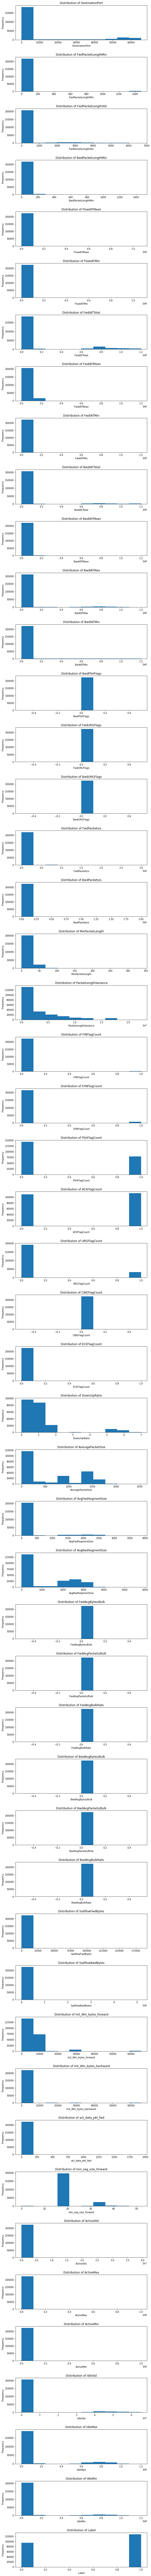

In [43]:
explore_features(df)

In [44]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [45]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'df' is your DataFrame with a 'Label' column
X = df.drop('Label', axis=1)  # Features
y = df['Label']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply undersampling to the training set
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Train a classifier on the resampled data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18887
           1       1.00      1.00      1.00     25736

    accuracy                           1.00     44623
   macro avg       1.00      1.00      1.00     44623
weighted avg       1.00      1.00      1.00     44623

Accuracy: 0.9999327700961388


## Modeling

In [46]:
n_samples, n_features = df.shape

n_features = n_features-1

X = df.drop(columns = ['Label'])
y = df['Label']

print(df.shape,X.shape,y.shape)

(223112, 50) (223112, 49) (223112,)


In [47]:
X.columns

Index(['DestinationPort', 'FwdPacketLengthMin', 'FwdPacketLengthStd',
       'BwdPacketLengthMin', 'FlowIATMean', 'FlowIATMin', 'FwdIATTotal',
       'FwdIATMean', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATMax',
       'BwdIATMin', 'BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags',
       'FwdPackets/s', 'BwdPackets/s', 'MinPacketLength',
       'PacketLengthVariance', 'FINFlagCount', 'SYNFlagCount', 'PSHFlagCount',
       'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount',
       'Down/UpRatio', 'AveragePacketSize', 'AvgFwdSegmentSize',
       'AvgBwdSegmentSize', 'FwdAvgBytes/Bulk', 'FwdAvgPackets/Bulk',
       'FwdAvgBulkRate', 'BwdAvgBytes/Bulk', 'BwdAvgPackets/Bulk',
       'BwdAvgBulkRate', 'SubflowFwdBytes', 'SubflowBwdBytes',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd',
       'min_seg_size_forward', 'ActiveStd', 'ActiveMax', 'ActiveMin',
       'IdleStd', 'IdleMax', 'IdleMin'],
      dtype='object')

In [48]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size =0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5)

In [49]:
X_train.shape, X_test.shape, X_val.shape

((156178, 49), (33467, 49), (33467, 49))

This code is performing feature selection by using the F-statistic (ANOVA) to select the top 15% of features based on their importance. This is commonly used in machine learning to reduce the dimensionality of the feature space and potentially improve model performance. The selected features are then used for training and testing machine learning models.

In [50]:
from sklearn.feature_selection import SelectPercentile, f_classif
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
selector=SelectPercentile(f_classif, percentile = 15)
X_new_train = selector.fit_transform(X_train,y_train)
X_new_test = selector.transform(X_test)
X_new_val = selector.transform(X_val)

In [51]:
X_new_train.shape,X_new_test.shape,X_new_val.shape

((156178, 8), (33467, 8), (33467, 8))

Scaling

In [52]:
X_train_scaled, X_val_scaled, X_test_scaled = data_scaling(X_train,X_val,X_test)

### LinearDiscriminantAnalysis

In [53]:
lda_model = LinearDiscriminantAnalysis()

Accuracy of LinearDiscriminantAnalysis(): 93.0767621836436%
F1 Score of LinearDiscriminantAnalysis(): 94.35525129729334%
              precision    recall  f1-score   support

    0:Benign       1.00      0.84      0.91     14102
    1:Attack       0.89      1.00      0.94     19365

    accuracy                           0.93     33467
   macro avg       0.95      0.92      0.93     33467
weighted avg       0.94      0.93      0.93     33467



(array([1, 1, 0, ..., 1, 1, 0], dtype=int64),
 LinearDiscriminantAnalysis(),
 93.0767621836436,
 94.35525129729334)

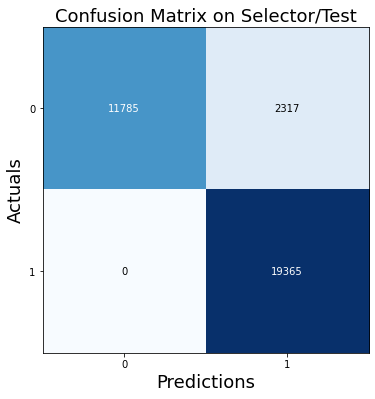

In [54]:
# lda With F Feature Selection Feature Selection
classification(lda_model, X_new_train, X_new_test, y_train, y_test,'Selector/Test')

##### With Unscaled Data

Accuracy of LinearDiscriminantAnalysis(): 98.0727283592793%
F1 Score of LinearDiscriminantAnalysis(): 98.34449834449835%
              precision    recall  f1-score   support

    0:Benign       1.00      0.96      0.98     14298
    1:Attack       0.97      1.00      0.98     19169

    accuracy                           0.98     33467
   macro avg       0.98      0.98      0.98     33467
weighted avg       0.98      0.98      0.98     33467



(array([1, 1, 0, ..., 1, 0, 0], dtype=int64),
 LinearDiscriminantAnalysis(),
 98.0727283592793,
 98.34449834449835)

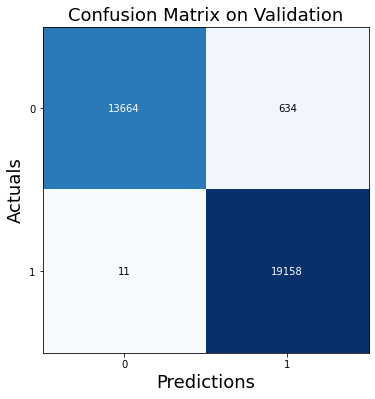

In [55]:
classification(lda_model, X_train, X_val, y_train, y_val,'Validation')

Accuracy of LinearDiscriminantAnalysis(): 98.0727283592793%
F1 Score of LinearDiscriminantAnalysis(): 98.36157187492061%
              precision    recall  f1-score   support

    0:Benign       1.00      0.95      0.98     14102
    1:Attack       0.97      1.00      0.98     19365

    accuracy                           0.98     33467
   macro avg       0.98      0.98      0.98     33467
weighted avg       0.98      0.98      0.98     33467



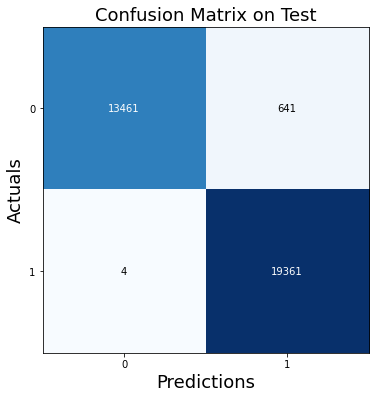

In [56]:
y_pred_lda_test,_,_,_ = classification(lda_model, X_train, X_test, y_train, y_test,'Test')

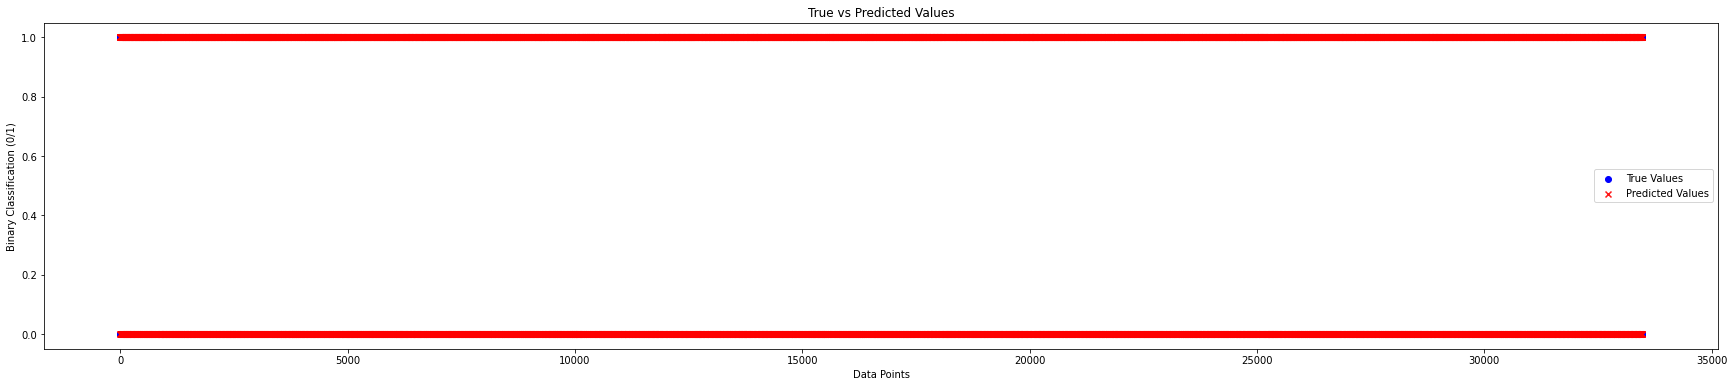

In [57]:
plot_predictions(y_test,y_pred_lda_test)

##### With Scaled Data

Accuracy of LinearDiscriminantAnalysis(): 98.0727283592793%
F1 Score of LinearDiscriminantAnalysis(): 98.34449834449835%
              precision    recall  f1-score   support

    0:Benign       1.00      0.96      0.98     14298
    1:Attack       0.97      1.00      0.98     19169

    accuracy                           0.98     33467
   macro avg       0.98      0.98      0.98     33467
weighted avg       0.98      0.98      0.98     33467



(array([1, 1, 0, ..., 1, 0, 0], dtype=int64),
 LinearDiscriminantAnalysis(),
 98.0727283592793,
 98.34449834449835)

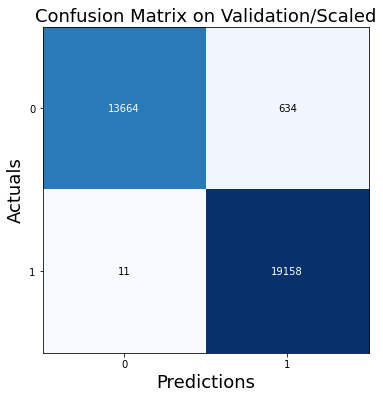

In [58]:
classification(lda_model, X_train_scaled, X_val_scaled, y_train, y_val,'Validation/Scaled')

Accuracy of LinearDiscriminantAnalysis(): 98.0727283592793%
F1 Score of LinearDiscriminantAnalysis(): 98.36157187492061%
              precision    recall  f1-score   support

    0:Benign       1.00      0.95      0.98     14102
    1:Attack       0.97      1.00      0.98     19365

    accuracy                           0.98     33467
   macro avg       0.98      0.98      0.98     33467
weighted avg       0.98      0.98      0.98     33467



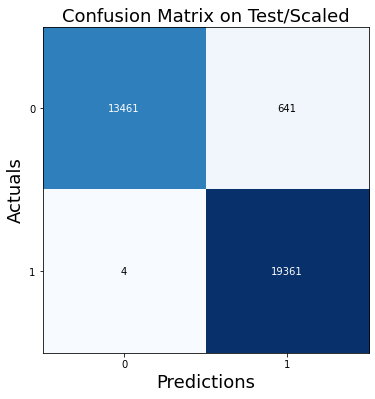

In [59]:
y_pred_lda_test,_,_,_ = classification(lda_model, X_train_scaled, X_test_scaled, y_train, y_test,'Test/Scaled')

In [60]:
y_pred_lda_test

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

### LDA Grid Search

In [61]:
lda_param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5],
    'priors': [None, [0.3, 0.7], [0.4, 0.6]],
    'n_components': [None, 2, 5],
    'store_covariance': [True, False],
    'tol': [0.0001, 0.001, 0.01],
}

In [62]:
# Perform grid search
lda_search_result = perform_grid_search(lda_model, lda_param_grid, X_train, y_train)

# Print the best parameters and the corresponding accuracy score
print("Best Parameters:", lda_search_result.best_params_)
print("Best Score:", lda_search_result.best_score_)

Best Parameters: {'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}
Best Score: 0.9809576225221734


In [63]:
best_lda_model = LinearDiscriminantAnalysis(solver='svd',store_covariance=True)

Accuracy of LinearDiscriminantAnalysis(store_covariance=True): 98.0727283592793%
F1 Score of LinearDiscriminantAnalysis(store_covariance=True): 98.36157187492061%
              precision    recall  f1-score   support

    0:Benign       1.00      0.95      0.98     14102
    1:Attack       0.97      1.00      0.98     19365

    accuracy                           0.98     33467
   macro avg       0.98      0.98      0.98     33467
weighted avg       0.98      0.98      0.98     33467



(array([1, 1, 0, ..., 1, 1, 0], dtype=int64),
 LinearDiscriminantAnalysis(store_covariance=True),
 98.0727283592793,
 98.36157187492061)

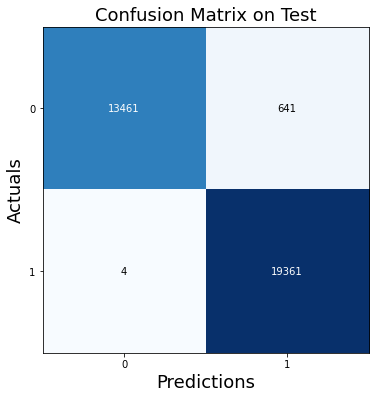

In [64]:
classification(best_lda_model, X_train, X_test, y_train, y_test,'Test')

### RandomForestClassifier

In [65]:
rf_model = RandomForestClassifier(n_estimators=15)

Accuracy of RandomForestClassifier(n_estimators=15): 99.95517972928558%
F1 Score of RandomForestClassifier(n_estimators=15): 99.96126133106065%
              precision    recall  f1-score   support

    0:Benign       1.00      1.00      1.00     14102
    1:Attack       1.00      1.00      1.00     19365

    accuracy                           1.00     33467
   macro avg       1.00      1.00      1.00     33467
weighted avg       1.00      1.00      1.00     33467



(array([1, 0, 0, ..., 1, 1, 0], dtype=int64),
 RandomForestClassifier(n_estimators=15),
 99.95517972928558,
 99.96126133106065)

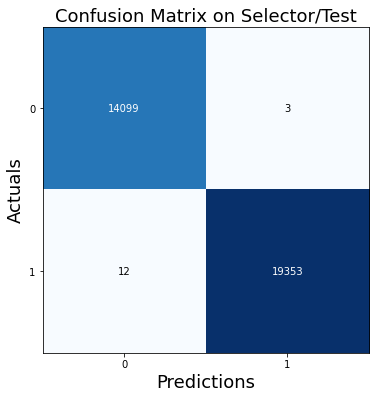

In [66]:
# RF With F Feature Selection Feature Selection
classification(rf_model, X_new_train, X_new_test, y_train, y_test,'Selector/Test')

Accuracy of RandomForestClassifier(n_estimators=15): 100.0%
F1 Score of RandomForestClassifier(n_estimators=15): 100.0%
              precision    recall  f1-score   support

    0:Benign       1.00      1.00      1.00     14298
    1:Attack       1.00      1.00      1.00     19169

    accuracy                           1.00     33467
   macro avg       1.00      1.00      1.00     33467
weighted avg       1.00      1.00      1.00     33467



(array([1, 1, 0, ..., 1, 0, 0], dtype=int64),
 RandomForestClassifier(n_estimators=15),
 100.0,
 100.0)

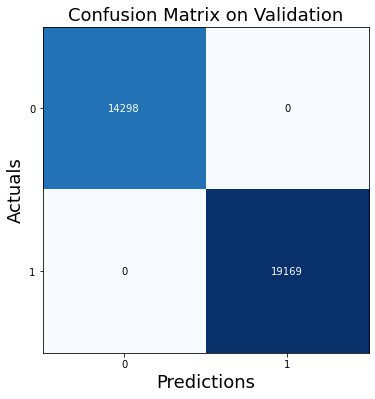

In [67]:
classification(rf_model, X_train, X_val, y_train, y_val,'Validation')

Accuracy of RandomForestClassifier(n_estimators=15): 100.0%
F1 Score of RandomForestClassifier(n_estimators=15): 100.0%
              precision    recall  f1-score   support

    0:Benign       1.00      1.00      1.00     14102
    1:Attack       1.00      1.00      1.00     19365

    accuracy                           1.00     33467
   macro avg       1.00      1.00      1.00     33467
weighted avg       1.00      1.00      1.00     33467



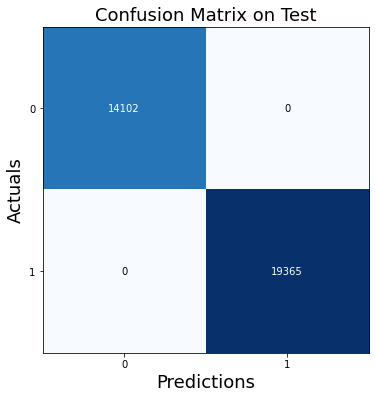

In [68]:
y_pred_rf_test,rf_clf, rf_acc, rf_f1  = classification(rf_model, X_train, X_test, y_train, y_test,'Test')

In [69]:
# create 10 folds for cross validation
folds = StratifiedKFold(n_splits = 10)

Accuracy_score: 99.94352612140987
precision_score: 99.93206521739131
recall_score: 99.96953505811773
f1_score: 99.95079662605436


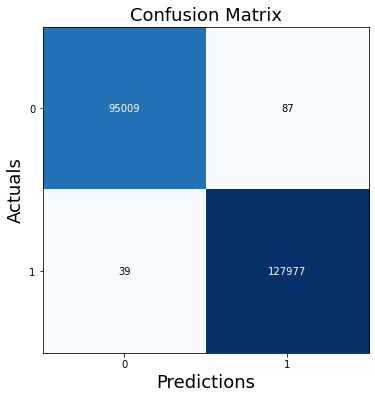

In [70]:
overall_cv_classification(rf_model, X, y,folds)

#### RF With Scaled

Accuracy of RandomForestClassifier(n_estimators=15): 99.99402396390474%
F1 Score of RandomForestClassifier(n_estimators=15): 99.99483577773188%
              precision    recall  f1-score   support

    0:Benign       1.00      1.00      1.00     14102
    1:Attack       1.00      1.00      1.00     19365

    accuracy                           1.00     33467
   macro avg       1.00      1.00      1.00     33467
weighted avg       1.00      1.00      1.00     33467



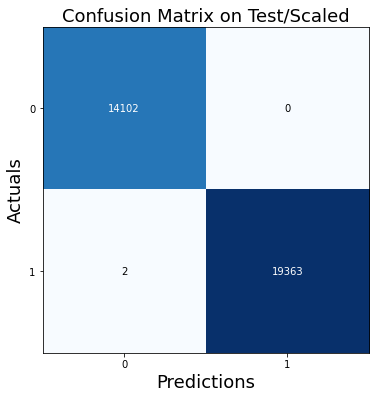

In [71]:
y_pred_rf_test_scaled,rf_clf_scaled, rf_acc_scaled, rf_f1_scaled = classification(rf_model, X_train_scaled, X_test_scaled, y_train, y_test,'Test/Scaled')

In [72]:
import pickle
from sklearn.pipeline import Pipeline
set_pipeline = Pipeline([
    ('classifier', rf_clf)
])
set_pipeline.fit(X_train, y_train)
model_filename = 'RandomForest.pkl'


pickle.dump(rf_clf, open(model_filename, 'wb'))
print(f"Model fitted and saved as {model_filename}")

Model fitted and saved as RandomForest.pkl


### XGBoost

In [73]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

Accuracy of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...): 99.99402396390474%
F1 Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enabl

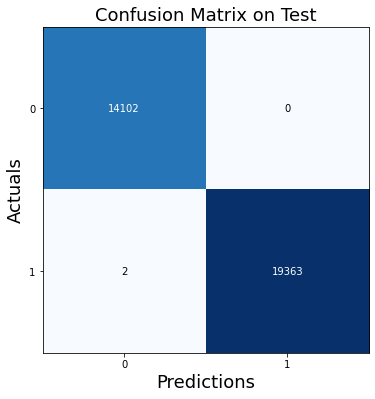

In [74]:
y_pred_xgb_test,_,_,_ = classification(xgb_model, X_train, X_test, y_train, y_test,'Test')

Accuracy of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...): 99.99402396390474%
F1 Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enabl

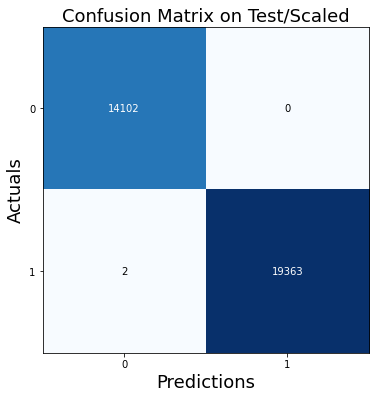

In [75]:
y_pred_xgb_test_scaled, xgb_clf_scaled, xgb_acc_scaled, xgb_f1_scaled = classification(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test,'Test/Scaled')

In [76]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are your datasets
# If you have a different way of splitting data, adjust accordingly

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert DataFrames to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Specify the watchlist with DMatrix objects
watchlist = [(dtrain, 'train'), (dval, 'validation')]

# Define the parameters
params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss', 
    'seed': 42  # seed for reproducibility
}

num_rounds = 1000  # number of boosting rounds 

# Train the model
model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=300)

# Predictions on the test set
dtest = xgb.DMatrix(X_test)
predictions = model.predict(dtest)

# Convert probabilities to binary predictions using a threshold
threshold = 0.5
binary_predictions = [1 if pred > threshold else 0 for pred in predictions]

[0]	train-logloss:0.43805	validation-logloss:0.43815
[1]	train-logloss:0.29714	validation-logloss:0.29731
[2]	train-logloss:0.20834	validation-logloss:0.20852
[3]	train-logloss:0.14896	validation-logloss:0.14922
[4]	train-logloss:0.10760	validation-logloss:0.10784
[5]	train-logloss:0.07842	validation-logloss:0.07869
[6]	train-logloss:0.05751	validation-logloss:0.05772
[7]	train-logloss:0.04238	validation-logloss:0.04258
[8]	train-logloss:0.03131	validation-logloss:0.03148
[9]	train-logloss:0.02322	validation-logloss:0.02338
[10]	train-logloss:0.01729	validation-logloss:0.01740
[11]	train-logloss:0.01293	validation-logloss:0.01303
[12]	train-logloss:0.00970	validation-logloss:0.00981
[13]	train-logloss:0.00732	validation-logloss:0.00742
[14]	train-logloss:0.00555	validation-logloss:0.00561
[15]	train-logloss:0.00421	validation-logloss:0.00425
[16]	train-logloss:0.00323	validation-logloss:0.00324
[17]	train-logloss:0.00249	validation-logloss:0.00252
[18]	train-logloss:0.00195	validation-

In [79]:
# Evaluate the model on the test set
accuracy = accuracy_score(y_test, binary_predictions)
conf_matrix = confusion_matrix(y_test, binary_predictions)
class_report = classification_report(y_test, binary_predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.9999

Confusion Matrix:
[[14102     0]
 [    2 19363]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14102
           1       1.00      1.00      1.00     19365

    accuracy                           1.00     33467
   macro avg       1.00      1.00      1.00     33467
weighted avg       1.00      1.00      1.00     33467



## Trying another approach for feature engineering by creating interaction terms and aggregating information

In [80]:
df2 = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

In [81]:
# Assuming df is your DataFrame
df2.columns = df2.columns.str.strip()

**Same preprocessing as above**

In [82]:
# Cleaning
df2 = handle_duplicates(df2)
df2 = handle_infinite_values(df2)
df2 = handle_nan_values(df2)

Count of Duplicated Records: 3940
Keeping first occurrence of duplicated records.
Shape Before Cleaning: (225745, 79),
Shape After Cleaning: (223112, 79)
Count of Rows with Infinite Values: 30
cleaning is done . . .
Count of NaN values:60
cleaning is done . . .


In [83]:
# Encoding
df2 = custom_encode(df2,'Label')

Categories : ['BENIGN' 'DDoS']
Encoded Categories : [0 1]


In [84]:
# delete both of them from features
df2 = df2.drop(columns = ['Flow Bytes/s', 'Flow Packets/s'], axis = 1)

columns = df2.columns.tolist()

In [85]:
# Handle highly or low correlated features
df2 = handle_correlated_features(df2,0.95,0.1)

No lowly correlated features found.
Highly Correlated Features:
Flow Duration - Fwd IAT Total : 0.9970498936526065
Total Fwd Packets - Total Backward Packets : 0.9568072946053905
Total Fwd Packets - Fwd Header Length : 0.9684386504944962
Total Fwd Packets - Fwd Header Length.1 : 0.9684386504944962
Total Fwd Packets - Subflow Fwd Packets : 1.0
Total Fwd Packets - Subflow Bwd Packets : 0.9568072946053905
Total Backward Packets - Total Length of Bwd Packets : 0.9704238286568636
Total Backward Packets - Bwd Header Length : 0.9755892317064044
Total Backward Packets - Subflow Fwd Packets : 0.9568072946053905
Total Backward Packets - Subflow Bwd Packets : 1.0
Total Backward Packets - Subflow Bwd Bytes : 0.9704238286568636
Total Length of Fwd Packets - Subflow Fwd Bytes : 1.0
Total Length of Bwd Packets - Subflow Bwd Packets : 0.9704238286568636
Total Length of Bwd Packets - Subflow Bwd Bytes : 1.0
Fwd Packet Length Max - Fwd Packet Length Std : 0.9916673951574841
Fwd Packet Length Mean - Avg 

In [86]:
df2.columns

Index(['Destination Port', 'Fwd Packet Length Min', 'Fwd Packet Length Std',
       'Bwd Packet Length Min', 'Flow IAT Mean', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Min', 'Bwd IAT Total',
       'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
       'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
       'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward',
       'Active Std', 'Active Max', 'Active Min', 'I

In [87]:
n_samples, n_features = df2.shape

n_features = n_features-1

X = df2.drop(columns = ['Label'])
y = df2['Label']

print(df2.shape,X.shape,y.shape)

(223112, 50) (223112, 49) (223112,)


In [88]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size =0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5)

In [89]:
# Combine features and labels for each set
train_set = pd.concat([X_train, y_train], axis=1)
val_set = pd.concat([X_val, y_val], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

In [90]:
test_set.columns

Index(['Destination Port', 'Fwd Packet Length Min', 'Fwd Packet Length Std',
       'Bwd Packet Length Min', 'Flow IAT Mean', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Min', 'Bwd IAT Total',
       'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
       'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
       'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward',
       'Active Std', 'Active Max', 'Active Min', 'I

Each interaction term and each summary statistic adds a new column to the dataset, contributing to the overall feature space. Depending on your analysis or machine learning model, these new features could potentially improve the model's performance by capturing important patterns or information in the data.

These features capture important information related to packet length, flow duration, traffic rates, TCP flags, and connection characteristics, which can be relevant for DDoS attack detection.

In [91]:
# List of selected features for aggregation
selected_features = [
    'Fwd Packet Length Min',
    'Fwd Packet Length Std',
    'Bwd Packet Length Min',
    'Flow IAT Mean',
    'Flow IAT Min',
    'Fwd Packets/s',
    'Bwd Packets/s',
    'FIN Flag Count',
    'SYN Flag Count',
    'PSH Flag Count',
    'ACK Flag Count',
    'Down/Up Ratio',
    'Init_Win_bytes_forward',
    'Init_Win_bytes_backward',
    'act_data_pkt_fwd'
]

Performing the aggregation on the training, validation, and test sets separately after splitting the data, there won't be data leakage. The key is to ensure that information from the validation or test set does not influence the aggregation on the training set, and vice versa.

To clarify, the approach you've taken—performing the aggregation after the data split—is a good practice to avoid data leakage, and apply it consistently to all sets (training, validation, and test).

In [92]:
# Aggregation on the training set
agg_train = train_set.groupby('Label').agg({feature: ['mean', 'max', 'min'] for feature in selected_features}).reset_index()

# Merge aggregated information back to the training set
train_set = pd.merge(train_set, agg_train, on='Label', how='left')

# Aggregation on the validation set
agg_val = val_set.groupby('Label').agg({feature: ['mean', 'max', 'min'] for feature in selected_features}).reset_index()

# Merge aggregated information back to the validation set
val_set = pd.merge(val_set, agg_val, on='Label', how='left')

# Aggregation on the test set
agg_test = test_set.groupby('Label').agg({feature: ['mean', 'max', 'min'] for feature in selected_features}).reset_index()

# Merge aggregated information back to the test set
test_set = pd.merge(test_set, agg_test, on='Label', how='left')

In [93]:
# Separate features and labels after aggregation
X_train = train_set.drop(columns=['Label'])
y_train = train_set['Label']

X_val = val_set.drop(columns=['Label'])
y_val = val_set['Label']

X_test = test_set.drop(columns=['Label'])
y_test = test_set['Label']

In [94]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

In [95]:
X_train.columns = [str(col) for col in X_train.columns]
X_test.columns = [str(col) for col in X_test.columns]
X_val.columns = [str(col) for col in X_val.columns]

In [96]:
from sklearn.feature_selection import SelectPercentile, f_classif
import numpy as np

np.seterr(divide='ignore', invalid='ignore')
selector=SelectPercentile(f_classif, percentile = 15)
X_new_train = selector.fit_transform(X_train,y_train)
X_new_test = selector.transform(X_test)
X_new_val = selector.transform(X_val)

In [97]:
X_new_train.shape,X_new_test.shape,X_new_val.shape

((156178, 14), (33467, 14), (33467, 14))

Accuracy of LinearDiscriminantAnalysis(): 100.0%
F1 Score of LinearDiscriminantAnalysis(): 100.0%
              precision    recall  f1-score   support

    0:Benign       1.00      1.00      1.00     14198
    1:Attack       1.00      1.00      1.00     19269

    accuracy                           1.00     33467
   macro avg       1.00      1.00      1.00     33467
weighted avg       1.00      1.00      1.00     33467



(array([1, 1, 0, ..., 0, 1, 0], dtype=int64),
 LinearDiscriminantAnalysis(),
 100.0,
 100.0)

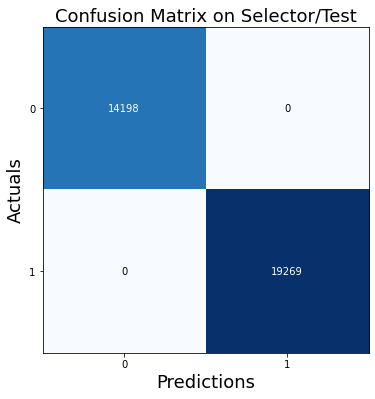

In [98]:
# lda With F Feature Selection Feature Selection
classification(lda_model, X_new_train, X_new_test, y_train, y_test,'Selector/Test')

Accuracy of LinearDiscriminantAnalysis(): 100.0%
F1 Score of LinearDiscriminantAnalysis(): 100.0%
              precision    recall  f1-score   support

    0:Benign       1.00      1.00      1.00     14441
    1:Attack       1.00      1.00      1.00     19026

    accuracy                           1.00     33467
   macro avg       1.00      1.00      1.00     33467
weighted avg       1.00      1.00      1.00     33467



(array([1, 1, 0, ..., 0, 1, 1], dtype=int64),
 LinearDiscriminantAnalysis(),
 100.0,
 100.0)

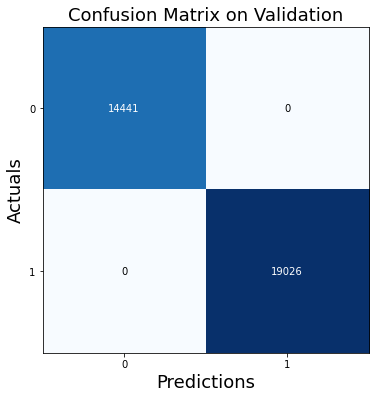

In [99]:
classification(lda_model, X_train, X_val, y_train, y_val,'Validation')

Accuracy of RandomForestClassifier(n_estimators=15): 100.0%
F1 Score of RandomForestClassifier(n_estimators=15): 100.0%
              precision    recall  f1-score   support

    0:Benign       1.00      1.00      1.00     14198
    1:Attack       1.00      1.00      1.00     19269

    accuracy                           1.00     33467
   macro avg       1.00      1.00      1.00     33467
weighted avg       1.00      1.00      1.00     33467



(array([1, 1, 0, ..., 0, 1, 0], dtype=int64),
 RandomForestClassifier(n_estimators=15),
 100.0,
 100.0)

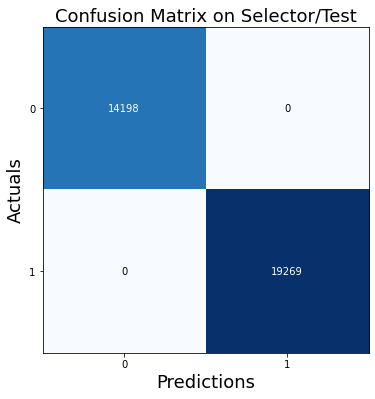

In [100]:
# RF With F Feature Selection Feature Selection
classification(rf_model, X_new_train, X_new_test, y_train, y_test,'Selector/Test')

# RFE

In [101]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

In [102]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
# Initialize models
lda = LinearDiscriminantAnalysis()
rf = RandomForestClassifier()

# Perform RFE for LDA
rfe_lda = RFE(estimator=lda, n_features_to_select=10)  # Select top 10 features
X_train_rfe_lda = rfe_lda.fit_transform(X_train, y_train)
X_test_rfe_lda = rfe_lda.transform(X_test)

# Train LDA with selected features
lda.fit(X_train_rfe_lda, y_train)
lda_predictions = lda.predict(X_test_rfe_lda)
lda_accuracy = accuracy_score(y_test, lda_predictions)
print("LDA Accuracy after RFE:", lda_accuracy)

LDA Accuracy after RFE: 0.8954799094637295


In [104]:
# Perform RFE for Random Forest
rfe_rf = RFE(estimator=rf, n_features_to_select=10)  # Select top 10 features
X_train_rfe_rf = rfe_rf.fit_transform(X_train, y_train)
X_test_rfe_rf = rfe_rf.transform(X_test)

# Train Random Forest with selected features
rf.fit(X_train_rfe_rf, y_train)
rf_predictions = rf.predict(X_test_rfe_rf)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy after RFE:", rf_accuracy)

Random Forest Accuracy after RFE: 0.9999327700961388
